# Condo Price Index and Venues Data Analysis of Toronto

## Introduction

Toronto is the largest city in Canada which has 2.93 million population and covers an area of 630 square kilometres. As one of the most multicultural urban areas in the world. Each year tens of thousands of newcomers from around the globe move to Toronto and settle down. The city is divided into 35 districts by the Toronto Real Estate Board (TREB).

As a newcomer, we want to find a conviniant area to live with relatively lower cost. Therefore, we can create a map and information chart where the real estate index is placed on Toronto and each district is clustered according to the venue which represent the conviniant level.

## Data Description

To consider the problem we can list the datas as below:

1. I found the list of Toronto Multiple listing service (MLS) districts and neighbourhoods within each district on __[Wikipedia](https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto)__.
2. I used **Google Maps API reverse geocoding** to find the cordinate of each neighbourhood, and culculated the cordinates of districts by culculating the centrel point of all the neighbourhoods within the district.
3. I used **Forsquare API** to get the venues of districts.
4. I found the price index of districts on __[TREB](https://trreb.ca/files/market-stats/home-price-index/TREB_MLS_HPI_Public_Tables_0321.pdf)__.

### Neighbourhoods

Let's firstly scrape the data from Wikipedia:

In [ ]:
import pandas as pd

In [84]:
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto')
df = data[9]

In [85]:
df.head()

,District Number,Neighbourhoods Included
0,C01,"Downtown, Harbourfront, Little Italy, Little P..."
1,C02,"The Annex, Yorkville, South Hill, Summerhill, ..."
2,C03,"Forest Hill South, Oakwood–Vaughan, Humewood–C..."
3,C04,"Bedford Park, Lawrence Manor, North Toronto, F..."
4,C06,"North York, Clanton Park, Bathurst Manor"


Now we can use Google Maps API geocoding to find cordinates for the districts:

In [286]:
import googlemaps
#gmaps = googlemaps.Client(key='')

In [ ]:
from statistics import mean
df["neighbourhoods"] = df["Neighbourhoods Included"]
for i in range(0,len(df["Neighbourhoods Included"])):
    df["neighbourhoods"][i] = df["Neighbourhoods Included"][i].split(", ")
df["lat"] = [0.0]*len(df[["neighbourhoods"]])
df["lng"] = [0.0]*len(df[["neighbourhoods"]])

for i in range(0,len(df["neighbourhoods"])):
    neighbourhoods_lat = list()
    neighbourhoods_lng = list()
    for g in range(0,len(df["neighbourhoods"][i])):
        neighbourhoodslist.append(df["neighbourhoods"][i][g])
        beighbourhood = df["neighbourhoods"][i][g] + ", Toronto, ON"
        geocode_result = gmaps.geocode(beighbourhood)
        latlist.append(geocode_result[0]["geometry"]["location"]["lat"])
        lnglist.append(geocode_result[0]["geometry"]["location"]["lng"])
        if 'neighborhood' in geocode_result[0]["types"]:
            if 'location' in geocode_result[0]["geometry"]:
                neighbourhoods_lat.append(geocode_result[0]["geometry"]["location"]["lat"])
                neighbourhoods_lng.append(geocode_result[0]["geometry"]["location"]["lng"])
            else:
                pass
    df["lat"][i] = mean(neighbourhoods_lat)
    df["lng"][i] = mean(neighbourhoods_lng)

In [382]:
df = df.drop(["neighbourhoods"], axis=1)
df.head()

,District Number,Neighbourhoods Included,lat,lng
0,C01,"Downtown, Harbourfront, Little Italy, Little P...",43.649651,-79.407145
1,C02,"The Annex, Yorkville, South Hill, Summerhill, ...",43.678110,-79.403615
2,C03,"Forest Hill South, Oakwood–Vaughan, Humewood–C...",43.689419,-79.431893
3,C04,"Bedford Park, Lawrence Manor, North Toronto, F...",43.719138,-79.418671
4,C06,"North York, Clanton Park, Bathurst Manor",43.755783,-79.451779


Let's see how it looks like on the map:

In [259]:
import folium

geocode_result2 = gmaps.geocode('Toronto, ON')
toronto = [geocode_result2[0]["geometry"]["location"]["lat"],geocode_result2[0]["geometry"]["location"]["lng"]]


map_torotno = folium.Map(location=toronto, zoom_start=11)
for district_mumber,lat, lon in zip(df["District Number"],df["lat"], df["lng"]):
    folium.Circle([lat, lon], radius=1100, color='red', fill=False).add_to(map_torotno)
    label = folium.Popup(str(district_mumber), parse_html=True)
    folium.Marker([lat, lon], popup=label).add_to(map_torotno)

In [260]:
map_torotno

### Foursquare

Now we can find all the venues for the districts:

In [263]:
import requests
#CLIENT_ID = '' # your Foursquare ID
#CLIENT_SECRET = '' # your Foursquare Secret
#VERSION = '20180605' # Foursquare API version
#LIMIT = 500 # A default Foursquare API limit value

In [333]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
toronto_venues = getNearbyVenues(names=df['District Number'],
                                   latitudes=df['lat'],
                                   longitudes=df['lng']
                                  )


In [334]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,C01,43.649651,-79.407145,#Hashtag Gallery,43.651830,-79.408103,Art Gallery
1,C01,43.649651,-79.407145,North of Brooklyn Pizzeria,43.646945,-79.406561,Pizza Place
2,C01,43.649651,-79.407145,Cumbrae's,43.646248,-79.408922,Butcher
3,C01,43.649651,-79.407145,Sud Forno,43.646208,-79.408986,Bakery
4,C01,43.649651,-79.407145,Dufflet Pastries,43.646306,-79.408456,Dessert Shop


In [335]:
c = toronto_venues.groupby('Neighborhood').count()
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot = toronto_onehot.drop(["Neighborhood"], axis=1)
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [336]:
c.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
C01,100,100,100,100,100,100
C02,47,47,47,47,47,47
C03,38,38,38,38,38,38
C04,27,27,27,27,27,27
C06,29,29,29,29,29,29


In [337]:
toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,C01,0.01,0.0,0.030000,0.0,0.0,0.01,0.01,0.01,0.0,...,0.020000,0.0,0.01,0.0,0.02,0.0,0.000000,0.01,0.03,0.0
1,C02,0.00,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,...,0.021277,0.0,0.00,0.0,0.00,0.0,0.000000,0.00,0.00,0.0
2,C03,0.00,0.0,0.026316,0.0,0.0,0.00,0.00,0.00,0.0,...,0.000000,0.0,0.00,0.0,0.00,0.0,0.000000,0.00,0.00,0.0
3,C04,0.00,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,...,0.000000,0.0,0.00,0.0,0.00,0.0,0.037037,0.00,0.00,0.0
4,C06,0.00,0.0,0.034483,0.0,0.0,0.00,0.00,0.00,0.0,...,0.000000,0.0,0.00,0.0,0.00,0.0,0.000000,0.00,0.00,0.0


In [338]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


### Price index

Now we load the price index, since it's on a PDF file, the easist way is to put it into a csv file:

In [399]:
price = pd.read_csv('houseprice.csv')
price = price.replace(',','', regex=True)
price = price.set_index('District Number')
price.head()

,Composite,Single Family Detached,Single Family Attached,Apartment
District Number,,,,
W01,1207400,1603000,1257100,659500
W02,1269700,1469500,1187200,717800
W03,956000,1039600,955400,562000
W04,856400,1033900,914100,521900
W05,740200,1057300,855800,440700


### Methodology

In order to analyse the venues for the districts, the first step is to implement the K-means algorithm to cluster the districts, and I tried to find out the optimum K value by using elbow method.

Second step is the visulization the price level on the map, we used a heat map to display the clusters and price level for each district. In this case, we use the price of Apartment.

Third step is to introduce the venue-price ratio which is the number of venues divided by the price, and find the districts which have the best value for money.

### Analysis

In [340]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from folium.plugins import HeatMap
import branca.colormap
from collections import defaultdict
import matplotlib.pyplot as plt

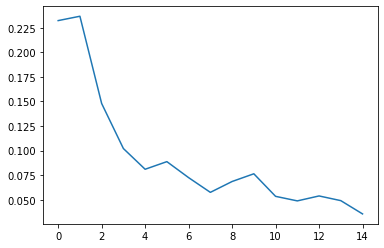

In [361]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
array_convt = toronto_grouped_clustering.values

def k_mean_distance(data, cantroid_matrix, i_centroid, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid
    distances = [np.linalg.norm(x-cantroid_matrix) for x in data[cluster_labels == i_centroid]]
    # return the mean value
    return np.mean(distances)



def total_distance (data, cantroid_matrix, cluster_labels):
    c_mean_distances = []
    for i, cent_features in enumerate(centroids):
        mean_distance = k_mean_distance(data, cent_features, i, cluster_labels)
        c_mean_distances.append(mean_distance)
    return np.mean(c_mean_distances)
    
total_dislist = list()
for i in range(1,16):
    kclusters = i
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
    cluster_labels = kmeans.labels_
    centroids = kmeans.cluster_centers_   
    total_dislist.append(total_distance(array_convt, centroids, cluster_labels))



plt.plot(total_dislist)

In [400]:
kclusters = 11
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

We are also interested what the most common venues in each district:

In [401]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District Number']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District Number'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,District Number,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,C01,Café,Bakery,Bar,Cocktail Bar,Pizza Place
1,C02,Café,Italian Restaurant,Sandwich Place,Coffee Shop,History Museum
2,C03,Italian Restaurant,Restaurant,Indian Restaurant,Convenience Store,Grocery Store
3,C04,Bank,Pharmacy,Skating Rink,Coffee Shop,Department Store
4,C06,Coffee Shop,Park,Pizza Place,Grocery Store,Mobile Phone Shop


In [402]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = df
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('District Number'), on='District Number', how='inner')

Now we can display the clusterd districts and price level on the map:

In [ ]:
map_clusters = folium.Map(location=toronto, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
toronto_merged = toronto_merged.join(price,on='District Number')
a = 'Apartment'
heat_data = toronto_merged[['lat','lng',a]]
heat_data[a] = heat_data[a].astype("float")
for lat, lon, poi, cluster,price in zip(toronto_merged['lat'], toronto_merged['lng'], toronto_merged['District Number'], toronto_merged['Cluster Labels'], heat_data[a]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Price ' + str(price), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
steps=5
colormap = branca.colormap.linear.YlOrRd_09.scale(min(heat_data[a]), max(heat_data[a])).to_step(steps)
gradient_map=defaultdict(dict)

b = max(heat_data[a])-min(heat_data[a])
for i in range(steps):
    gradient_map[1/steps*i] = colormap.rgb_hex_str(min(heat_data[a]) + b/steps*i)
colormap.add_to(map_clusters) #add color bar at the top of the map
HeatMap(heat_data,gradient = gradient_map, radius = 30).add_to(map_clusters)


In [404]:
map_clusters

Then we want to see which districts have higher value for money:

In [ ]:
heat_data = toronto_merged[['lat','lng',a]]
heat_data[a] = heat_data[a].astype("float")
map_venus = folium.Map(location=toronto, zoom_start=11)
toronto_merged = toronto_merged.join(c['Venue Category'],on='District Number')
for lat, lon, poi, cluster,price in zip(toronto_merged['lat'], toronto_merged['lng'], toronto_merged['District Number'], toronto_merged['Cluster Labels'], heat_data[a]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Price ' + str(price), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_venus)
heat_data = toronto_merged[['lat', 'lng']]
heat_data['Venue Ratio'] = toronto_merged['Venue Category'].astype("float")/toronto_merged[a].astype("float")*100000
# add markers to the map
steps=5

colormap = branca.colormap.linear.YlOrRd_09.scale(0, 1).to_step(steps)
gradient_map=defaultdict(dict)


for i in range(steps):
    gradient_map[1/steps*i] = colormap.rgb_hex_str(1/steps*i)
HeatMap(heat_data, radius = 30).add_to(map_venus)

In [406]:
map_venus

Finally we selected the top 5 districts with the best value for money:

In [407]:
toronto_merged['Venue Ratio'] = heat_data['Venue Ratio']

top5 = toronto_merged.nlargest(5, 'Venue Ratio')

top5[['District Number','Neighbourhoods Included','Venue Ratio']]

,District Number,Neighbourhoods Included,Venue Ratio
6,C08,"Cabbagetown, St. Lawrence Market, Toronto wate...",15.787812
0,C01,"Downtown, Harbourfront, Little Italy, Little P...",14.617746
25,W01,"High Park, South Parkdale, Swansea, Roncesvall...",14.404852
26,W02,"Bloor West Village, Baby Point, The Junction (...",11.145166
12,C14,"Newtonbrook East, Willowdale East, Newtonbrook",10.920011


In [408]:
map_top5 = folium.Map(location=toronto, zoom_start=11)
for district_mumber,lat, lon in zip(top5["District Number"],top5["lat"], top5["lng"]):
    label = folium.Popup(str(district_mumber), parse_html=True)
    folium.Marker([lat, lon], popup=label).add_to(map_top5)

In [409]:
map_top5

# Results and Discussion

During the model selection process, we found out that the venues in Toronto districtions are highly schismatic: most venues are concentrated in certain districtions. This causes difficulty for K-means model since it tries to include all the outliers, so the optimal K value under the elbow is not the best fit in our data set. Therefore, I selected 11 as my K value which shows more than one cluster other than outliers (which implied about 7 outliers which is clusterd with itself).

# Conclusion

When we culculate the Venue Ratio, we multiplied the result by 100000 to display the difference since the number of venue and the price are not in same Magnitude. Eventially we found the top 5 distrcts that are most conviniant with ralitively cheaper price for appartments. They are C08, C01, W01. W02 and C14